
## A Multilayer Perceptron Tutorial with Wine Quality Data

In this notebook, we will:

- Load and explore the WineQT dataset.
- Frame wine quality prediction as a **multiclass classification** problem.
- Train a simple **baseline model** (logistic regression).
- Train a **Multilayer Perceptron (MLP)** neural network.
- Investigate how the **width of the hidden layer** (number of neurons) affects:
  - Training accuracy
  - Test accuracy
  - Overfitting / underfitting behaviour
- Visualise the results and discuss limitations.




In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# For nicer plots in Jupyter
%matplotlib inline

# Set a global random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Load and inspect the dataset

We start by loading the WineQT dataset from a CSV file.

Typical columns include:

- Physicochemical features (e.g. `fixed acidity`, `citric acid`, `alcohol`, etc.)
- A target variable `quality` (integer score)
- An identifier column `Id` which we will drop.


In [2]:

csv_path = "WineQT.csv"

df = pd.read_csv(csv_path)

print("Shape of the raw dataset:", df.shape)
df.head()


Shape of the raw dataset: (1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


### 1.1 Basic information and cleaning

We check:

- Data types
- Missing values
- Basic statistics

We will also:

- Drop the `Id` column (it is just an identifier and not a useful feature).


In [3]:
# Show info about types and non-null counts
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [4]:
# Check for missing values
df.isna().sum()


,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


In [5]:
# Drop the Id column if present
if "Id" in df.columns:
    df = df.drop(columns=["Id"])
    print("Dropped 'Id' column. New shape:", df.shape)
else:
    print("'Id' column not found. Shape unchanged:", df.shape)

# Basic statistics
df.describe()


Dropped 'Id' column. New shape: (1143, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### 1.2 Target variable: wine quality distribution

Next, let's look at how the `quality` scores are distributed.

This helps us understand:

- Class imbalance
- Which quality scores are common or rare


quality
3      6
4     33
5    483
6    462
7    143
8     16
Name: count, dtype: int64


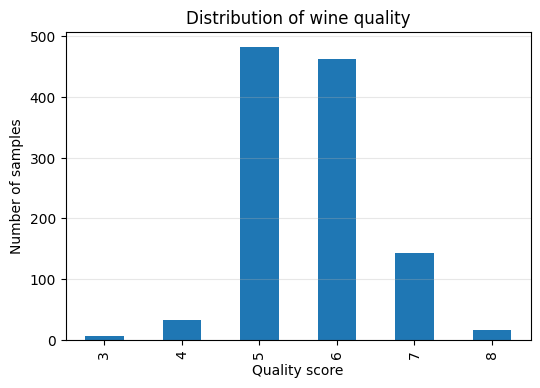

<Figure size 640x480 with 0 Axes>

In [6]:
quality_counts = df["quality"].value_counts().sort_index()
print(quality_counts)

plt.figure(figsize=(6, 4))
quality_counts.plot(kind="bar")
plt.xlabel("Quality score")
plt.ylabel("Number of samples")
plt.title("Distribution of wine quality")
plt.grid(axis="y", alpha=0.3)
plt.show()

plt.tight_layout()
plt.savefig("quality_distribution.png", dpi=300)
plt.show()


## 2. Prepare features and train/test split

We now separate:

- **Features** `X`: all columns except `quality`
- **Target** `y`: the `quality` column

Then we perform a **train/test split**:

- 80% for training
- 20% for testing
- Stratified by `quality` to preserve the class distribution


In [7]:
# Features and target
X = df.drop(columns=["quality"])
y = df["quality"]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Feature matrix shape: (1143, 11)
Target vector shape: (1143,)
Training set size: 914
Test set size: 229


### 2.1 Feature scaling

Multilayer Perceptrons (MLPs) work best when input features are on a **similar scale**.

We standardise each feature to have:

- Mean 0
- Standard deviation 1

using `StandardScaler`.


In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled training features shape:", X_train_scaled.shape)
print("Scaled test features shape:", X_test_scaled.shape)


Scaled training features shape: (914, 11)
Scaled test features shape: (229, 11)


## 3. Baseline model: Multinomial Logistic Regression

Before using a neural network, we train a simple **multinomial logistic regression** model.

This gives us a **baseline** to compare the MLP against.


In [9]:
log_reg = LogisticRegression(
    multi_class="multinomial",
    max_iter=1000,
    random_state=RANDOM_STATE
)

log_reg.fit(X_train_scaled, y_train)

y_train_pred_lr = log_reg.predict(X_train_scaled)
y_test_pred_lr = log_reg.predict(X_test_scaled)

train_acc_lr = accuracy_score(y_train, y_train_pred_lr)
test_acc_lr = accuracy_score(y_test, y_test_pred_lr)

print(f"Logistic Regression training accuracy: {train_acc_lr:.4f}")
print(f"Logistic Regression test accuracy:     {test_acc_lr:.4f}")


Logistic Regression training accuracy: 0.6072
Logistic Regression test accuracy:     0.6245


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [10]:
print("Classification report (Logistic Regression, test set):")
print(classification_report(y_test, y_test_pred_lr))


Classification report (Logistic Regression, test set):
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7
           5       0.70      0.78      0.74        97
           6       0.59      0.63      0.61        92
           7       0.43      0.31      0.36        29
           8       0.00      0.00      0.00         3

    accuracy                           0.62       229
   macro avg       0.29      0.29      0.28       229
weighted avg       0.59      0.62      0.60       229



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 4. Multilayer Perceptron (MLP) and hidden layer width

A **Multilayer Perceptron (MLP)** is a feed-forward neural network with:

- An input layer (our features)
- One or more hidden layers
- An output layer (class probabilities via softmax)

In this experiment, we use **one hidden layer** and vary its **width**:

- Widths = `[8, 16, 32, 64, 128]`

For each width, we will:

1. Train an MLP on the training data.
2. Measure accuracy on:
   - Training set
   - Test set
3. Store the results for comparison.

This allows us to study **underfitting vs overfitting** as we increase model capacity.


In [11]:
hidden_layer_sizes_list = [8, 16, 32, 64, 128]

results = []

for width in hidden_layer_sizes_list:
    print(f"\nTraining MLP with hidden layer width = {width}")

    mlp = MLPClassifier(
        hidden_layer_sizes=(width,),
        activation="relu",
        solver="adam",
        alpha=0.0001,       # L2 regularisation strength
        max_iter=500,
        random_state=RANDOM_STATE
    )

    mlp.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = mlp.predict(X_train_scaled)
    y_test_pred = mlp.predict(X_test_scaled)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    results.append({
        "width": width,
        "train_acc": train_acc,
        "test_acc": test_acc
    })

    print(f"  Train accuracy: {train_acc:.4f}")
    print(f"  Test accuracy:  {test_acc:.4f}")

results



Training MLP with hidden layer width = 8


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train accuracy: 0.6499
  Test accuracy:  0.6288

Training MLP with hidden layer width = 16


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train accuracy: 0.6674
  Test accuracy:  0.6288

Training MLP with hidden layer width = 32


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train accuracy: 0.7024
  Test accuracy:  0.6332

Training MLP with hidden layer width = 64


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Train accuracy: 0.7538
  Test accuracy:  0.6332

Training MLP with hidden layer width = 128
  Train accuracy: 0.8392
  Test accuracy:  0.6288


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[{'width': 8, 'train_acc': 0.649890590809628, 'test_acc': 0.62882096069869},
 {'width': 16, 'train_acc': 0.6673960612691466, 'test_acc': 0.62882096069869},
 {'width': 32,
  'train_acc': 0.7024070021881839,
  'test_acc': 0.6331877729257642},
 {'width': 64,
  'train_acc': 0.7538293216630197,
  'test_acc': 0.6331877729257642},
 {'width': 128, 'train_acc': 0.8391684901531729, 'test_acc': 0.62882096069869}]

### 4.1 Results: width vs accuracy

We now convert our list of results into a DataFrame and plot:

- Training accuracy vs width
- Test accuracy vs width

This will visualise how model capacity affects performance.


In [12]:
res_df = pd.DataFrame(results)
res_df


,width,train_acc,test_acc
0,8,0.649891,0.628821
1,16,0.667396,0.628821
2,32,0.702407,0.633188
3,64,0.753829,0.633188
4,128,0.839168,0.628821


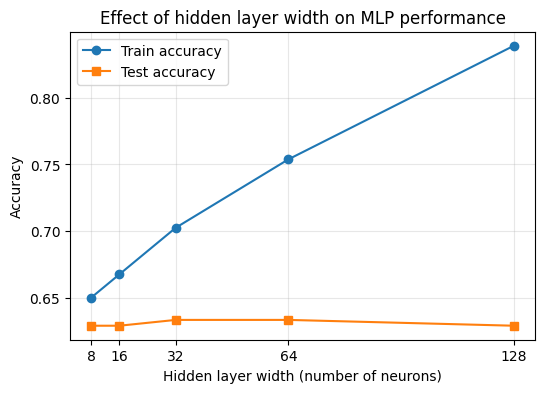

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(res_df["width"], res_df["train_acc"], marker="o", label="Train accuracy")
plt.plot(res_df["width"], res_df["test_acc"], marker="s", label="Test accuracy")
plt.xlabel("Hidden layer width (number of neurons)")
plt.ylabel("Accuracy")
plt.title("Effect of hidden layer width on MLP performance")
plt.xticks(res_df["width"])
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

plt.tight_layout()
plt.savefig("width_vs_accuracy.png", dpi=300)
plt.show()


### 4.2 Interpreting the width vs accuracy plot

From the plot, we can typically observe:

- **Small widths (e.g. 8 units)**:
  - Lower training and test accuracy
  - The model may be **underfitting** (too simple to capture the patterns).

- **Moderate widths (e.g. 32 or 64 units)**:
  - Higher test accuracy
  - A good trade-off between underfitting and overfitting.

- **Very large widths (e.g. 128 units)**:
  - Training accuracy might become very high (close to 1.0).
  - Test accuracy may not improve, or might even **decrease**.
  - This suggests **overfitting**: the model memorises training data but generalises worse.


## 5. Inspect the best-performing MLP

Next, we:

1. Find the width that gives the **highest test accuracy**.
2. Train a final MLP model using that width.
3. Analyse its performance in more detail, including a **confusion matrix**.


In [14]:
# Find the row with the best test accuracy
best_row = res_df.iloc[res_df["test_acc"].idxmax()]
best_width = int(best_row["width"])
best_test_acc = best_row["test_acc"]

print(f"Best hidden layer width: {best_width}")
print(f"Best test accuracy:      {best_test_acc:.4f}")


Best hidden layer width: 32
Best test accuracy:      0.6332


In [15]:
# Train a final model with the best width
best_mlp = MLPClassifier(
    hidden_layer_sizes=(best_width,),
    activation="relu",
    solver="adam",
    alpha=0.0001,
    max_iter=500,
    random_state=RANDOM_STATE
)

best_mlp.fit(X_train_scaled, y_train)

y_test_pred_best = best_mlp.predict(X_test_scaled)

final_test_acc = accuracy_score(y_test, y_test_pred_best)
print(f"Final test accuracy (width={best_width}): {final_test_acc:.4f}")


Final test accuracy (width=32): 0.6332


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
print("Classification report (best MLP, test set):")
print(classification_report(y_test, y_test_pred_best))


Classification report (best MLP, test set):
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7
           5       0.73      0.76      0.74        97
           6       0.61      0.65      0.63        92
           7       0.44      0.38      0.41        29
           8       0.00      0.00      0.00         3

    accuracy                           0.63       229
   macro avg       0.30      0.30      0.30       229
weighted avg       0.61      0.63      0.62       229



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 5.1 Confusion matrix

A confusion matrix lets us see **which quality scores are confused** with each other.

For example, a model might:

- Often confuse classes 5 and 6
- Rarely confuse 3 with 8

This is useful for understanding model behaviour beyond a single accuracy number.


Confusion matrix:
[[ 0  0  1  0  0  0]
 [ 0  0  4  3  0  0]
 [ 0  0 74 19  4  0]
 [ 0  1 20 60 10  1]
 [ 0  0  3 14 11  1]
 [ 0  0  0  3  0  0]]


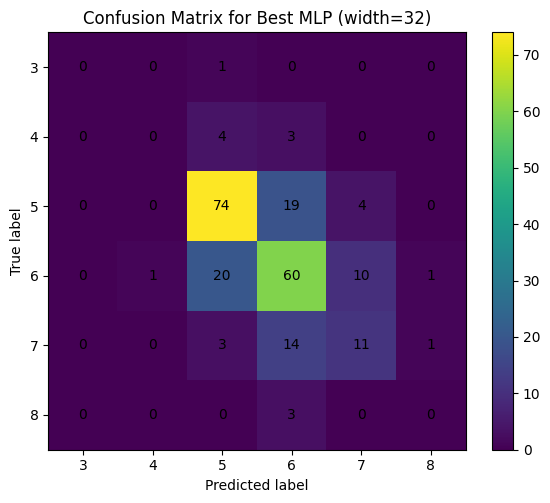

In [17]:
cm = confusion_matrix(y_test, y_test_pred_best)
labels = sorted(y.unique())

print("Confusion matrix:")
print(cm)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm)

# Axis labels
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Confusion Matrix for Best MLP (width={best_width})")

# Annotate counts in each cell
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar(im)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


## 6. Discussion and limitations

### 6.1 Summary of findings

- We trained a **baseline logistic regression** model and an **MLP** on the WineQT dataset.
- By varying the **hidden layer width**, we observed:
  - Small models underfit (low train and test accuracy).
  - Larger models achieve higher train accuracy, but do not always improve test accuracy.
  - There is a **sweet spot** (e.g. around the best width we found) where test performance is highest.

This illustrates the classic **bias–variance trade-off**:
- Narrow networks → high bias, low variance (underfitting).
- Very wide networks → low bias, high variance (overfitting).
- Moderate width → best generalisation.

### 6.2 Limitations

- We only tuned a **single hyperparameter** (hidden layer width).
- Other important hyperparameters:
  - Number of hidden layers (network depth)
  - Regularisation strength `alpha`
  - Learning rate
  - Training epochs (`max_iter`)
- The `quality` labels themselves may be **subjective**.
- The dataset size is moderate; deeper networks might need more data.

